In [1]:
import argparse
import os
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
def mpl_plot(filename, outputs, fft=False):
    """Plots electric and magnetic fields and currents from all receiver points in the given output file. Each receiver point is plotted in a new figure window.

    Args:
        filename (string): Filename (including path) of output file.
        outputs (list): List of field/current components to plot.
        fft (boolean): Plot FFT switch.

    Returns:
        plt (object): matplotlib plot object.
    """

    # Open output file and read some attributes
    f = h5py.File(filename, 'r')
    nrx = f.attrs['nrx']
    dt = f.attrs['dt']
    iterations = f.attrs['Iterations']
    time = np.linspace(0, (iterations - 1) * dt, num=iterations)

    # Check there are any receivers
    if nrx == 0:
        raise Exception('No receivers found in {}'.format(filename))

    # Check for single output component when doing a FFT
    if fft:
        if not len(outputs) == 1:
            raise Exception('A single output must be specified when using the -fft option')

    # New plot for each receiver
    for rx in range(1, nrx + 1):
        path = '/rxs/rx' + str(rx) + '/'
        availableoutputs = list(f[path].keys())

        # If only a single output is required, create one subplot
        if len(outputs) == 1:

            # Check for polarity of output and if requested output is in file
            if outputs[0][-1] == '-':
                polarity = -1
                outputtext = '-' + outputs[0][0:-1]
                output = outputs[0][0:-1]
            else:
                polarity = 1
                outputtext = outputs[0]
                output = outputs[0]

            if output not in availableoutputs:
                raise Exception('{} output requested to plot, but the available output for receiver 1 is {}'.format(output, ', '.join(availableoutputs)))

            outputdata = f[path + output][:] * polarity

            # Plotting if FFT required
            if fft:
                # FFT
                freqs, power = fft_power(outputdata, dt)
                freqmaxpower = np.where(np.isclose(power, 0))[0][0]

                # Set plotting range to -60dB from maximum power or 4 times
                # frequency at maximum power
                try:
                    pltrange = np.where(power[freqmaxpower:] < -60)[0][0] + freqmaxpower + 1
                except:
                    pltrange = freqmaxpower * 4

                pltrange = np.s_[0:pltrange]

                # Plot time history of output component
                fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, num='rx' + str(rx), figsize=(20, 10), facecolor='w', edgecolor='w')
                line1 = ax1.plot(time, outputdata, 'r', lw=2, label=outputtext)
                ax1.set_xlabel('Time [s]')
                ax1.set_ylabel(outputtext + ' field strength [V/m]')
                ax1.set_xlim([0, np.amax(time)])
                ax1.grid(which='both', axis='both', linestyle='-.')

                # Plot frequency spectra
                markerline, stemlines, baseline = ax2.stem(freqs[pltrange], power[pltrange], '-.', use_line_collection=True)
                plt.setp(baseline, 'linewidth', 0)
                plt.setp(stemlines, 'color', 'r')
                plt.setp(markerline, 'markerfacecolor', 'r', 'markeredgecolor', 'r')
                line2 = ax2.plot(freqs[pltrange], power[pltrange], 'r', lw=2)
                ax2.set_xlabel('Frequency [Hz]')
                ax2.set_ylabel('Power [dB]')
                ax2.grid(which='both', axis='both', linestyle='-.')

                # Change colours and labels for magnetic field components or currents
                if 'H' in outputs[0]:
                    plt.setp(line1, color='g')
                    plt.setp(line2, color='g')
                    plt.setp(ax1, ylabel=outputtext + ' field strength [A/m]')
                    plt.setp(stemlines, 'color', 'g')
                    plt.setp(markerline, 'markerfacecolor', 'g', 'markeredgecolor', 'g')
                elif 'I' in outputs[0]:
                    plt.setp(line1, color='b')
                    plt.setp(line2, color='b')
                    plt.setp(ax1, ylabel=outputtext + ' current [A]')
                    plt.setp(stemlines, 'color', 'b')
                    plt.setp(markerline, 'markerfacecolor', 'b', 'markeredgecolor', 'b')

                plt.show()

            # Plotting if no FFT required
            else:
                fig, ax = plt.subplots(subplot_kw=dict(xlabel='Time [s]', ylabel=outputtext + ' field strength [V/m]'), num='rx' + str(rx), figsize=(20, 10), facecolor='w', edgecolor='w')
                line = ax.plot(time, outputdata, 'r', lw=2, label=outputtext)
                ax.set_xlim([0, np.amax(time)])
                # ax.set_ylim([-15, 20])
                ax.grid(which='both', axis='both', linestyle='-.')

                if 'H' in output:
                    plt.setp(line, color='g')
                    plt.setp(ax, ylabel=outputtext + ', field strength [A/m]')
                elif 'I' in output:
                    plt.setp(line, color='b')
                    plt.setp(ax, ylabel=outputtext + ', current [A]')

        # If multiple outputs required, create all nine subplots and populate only the specified ones
        else:
            fig, ax = plt.subplots(subplot_kw=dict(xlabel='Time [s]'), num='rx' + str(rx), figsize=(20, 10), facecolor='w', edgecolor='w')
            if len(outputs) == 9:
                gs = gridspec.GridSpec(3, 3, hspace=0.3, wspace=0.3)
            else:
                gs = gridspec.GridSpec(3, 2, hspace=0.3, wspace=0.3)

            for output in outputs:
                # Check for polarity of output and if requested output is in file
                if output[-1] == 'm':
                    polarity = -1
                    outputtext = '-' + output[0:-1]
                    output = output[0:-1]
                else:
                    polarity = 1
                    outputtext = output

                # Check if requested output is in file
                if output not in availableoutputs:
                    raise Exception('Output(s) requested to plot: {}, but available output(s) for receiver {} in the file: {}'.format(', '.join(outputs), rx, ', '.join(availableoutputs)))

                outputdata = f[path + output][:] * polarity

                if output == 'Ex':
                    ax = plt.subplot(gs[0, 0])
                    ax.plot(time, outputdata, 'r', lw=2, label=outputtext)
                    ax.set_ylabel(outputtext + ', field strength [V/m]')
                # ax.set_ylim([-15, 20])
                elif output == 'Ey':
                    ax = plt.subplot(gs[1, 0])
                    ax.plot(time, outputdata, 'r', lw=2, label=outputtext)
                    ax.set_ylabel(outputtext + ', field strength [V/m]')
                # ax.set_ylim([-15, 20])
                elif output == 'Ez':
                    ax = plt.subplot(gs[2, 0])
                    ax.plot(time, outputdata, 'r', lw=2, label=outputtext)
                    ax.set_ylabel(outputtext + ', field strength [V/m]')
                # ax.set_ylim([-15, 20])
                elif output == 'Hx':
                    ax = plt.subplot(gs[0, 1])
                    ax.plot(time, outputdata, 'g', lw=2, label=outputtext)
                    ax.set_ylabel(outputtext + ', field strength [A/m]')
                # ax.set_ylim([-0.03, 0.03])
                elif output == 'Hy':
                    ax = plt.subplot(gs[1, 1])
                    ax.plot(time, outputdata, 'g', lw=2, label=outputtext)
                    ax.set_ylabel(outputtext + ', field strength [A/m]')
                # ax.set_ylim([-0.03, 0.03])
                elif output == 'Hz':
                    ax = plt.subplot(gs[2, 1])
                    ax.plot(time, outputdata, 'g', lw=2, label=outputtext)
                    ax.set_ylabel(outputtext + ', field strength [A/m]')
                # ax.set_ylim([-0.03, 0.03])
                elif output == 'Ix':
                    ax = plt.subplot(gs[0, 2])
                    ax.plot(time, outputdata, 'b', lw=2, label=outputtext)
                    ax.set_ylabel(outputtext + ', current [A]')
                elif output == 'Iy':
                    ax = plt.subplot(gs[1, 2])
                    ax.plot(time, outputdata, 'b', lw=2, label=outputtext)
                    ax.set_ylabel(outputtext + ', current [A]')
                elif output == 'Iz':
                    ax = plt.subplot(gs[2, 2])
                    ax.plot(time, outputdata, 'b', lw=2, label=outputtext)
                    ax.set_ylabel(outputtext + ', current [A]')
            for ax in fig.axes:
                ax.set_xlim([0, np.amax(time)])
                ax.grid(which='both', axis='both', linestyle='-.')

        # Save a PDF/PNG of the figure
        # fig.savefig(os.path.splitext(os.path.abspath(filename))[0] + '_rx' + str(rx) + '.pdf', dpi=None, format='pdf', bbox_inches='tight', pad_inches=0.1)
        # fig.savefig(os.path.splitext(os.path.abspath(filename))[0] + '_rx' + str(rx) + '.png', dpi=150, format='png', bbox_inches='tight', pad_inches=0.1)

    f.close()

    return plt

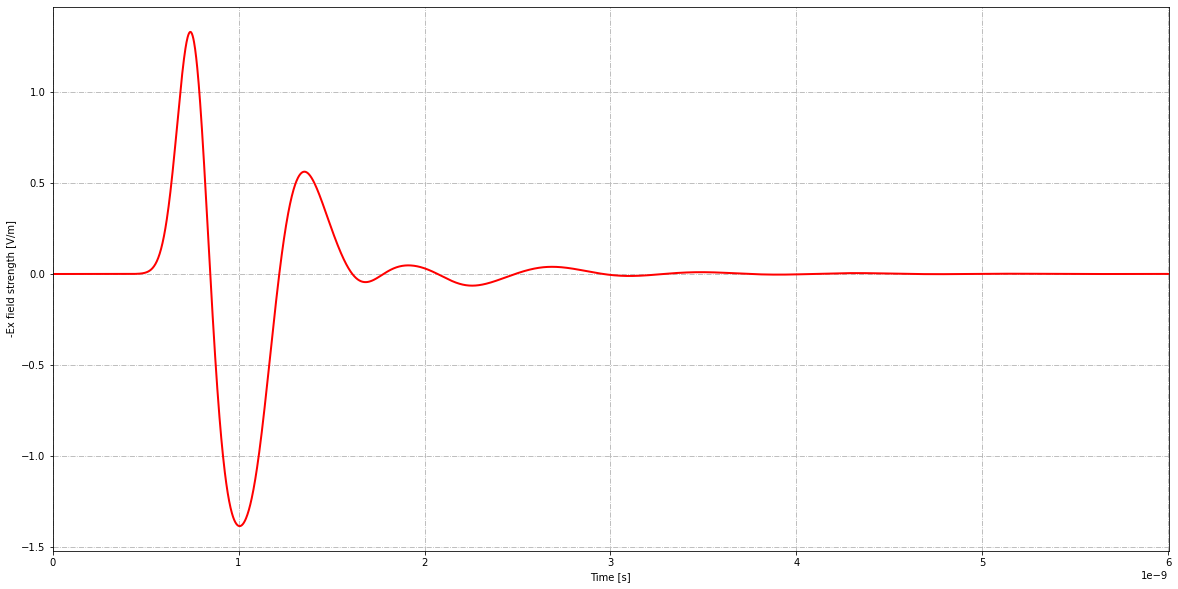

In [7]:
plthandle = mpl_plot("antenna_gssi_opt_final13.out", ["Ex-"])
plthandle.show()

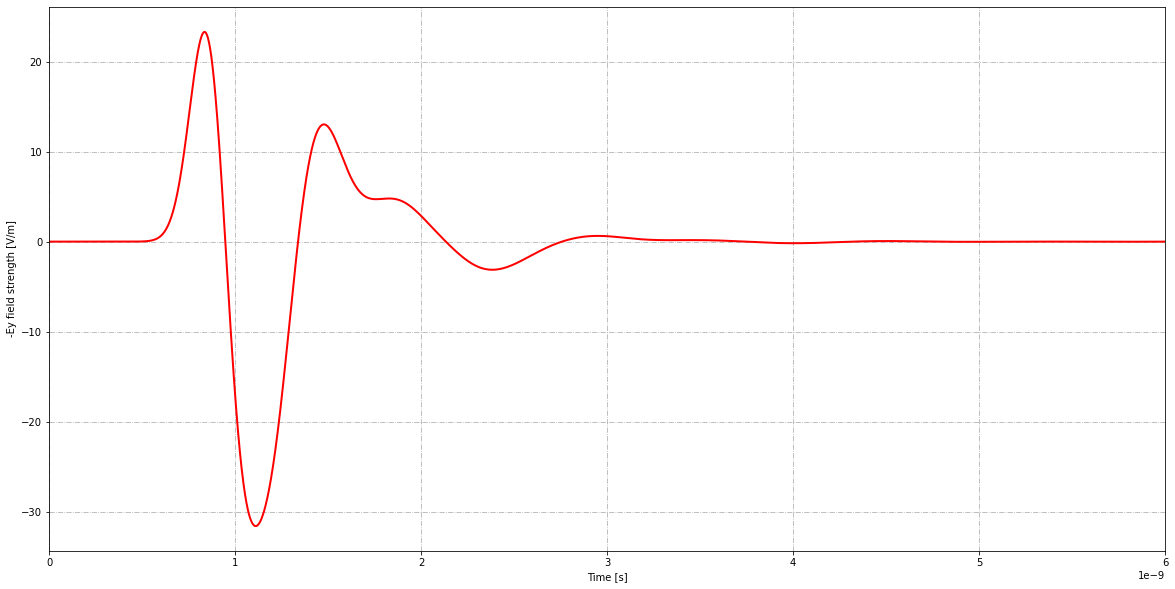

In [9]:
plthandle = mpl_plot("antenna_gssi_base.out", ["Ey-"])
plthandle.show()